In [183]:
from sqlalchemy import create_engine
import pandas as pd
import re

In [184]:
engine = create_engine('sqlite:///testDB.sqlite3')
connection = engine.raw_connection()

Построение таблицы для план-факт анализа из базы данных.

Таблица плана:
Согласно структуре базы, плановые данные по продажам можно получить только в разрезе сервисных центров (СЦ), но не по клиентам. Поэтому итоговая таблица план-факта была построена в разрезе сервисных центров. Также в связи с невозможностью привязать клиента к плановым продажам, код региона был взят из таблицы Agents, т.е. привязанный к сервисному центру, а не к клиенту. Было проверено, что код региона сервисного центра не всегда совпадает с кодом региона клиента, но для региона 77 в большинстве случаев совпадает, поэтому было сделано такое допущение.
Таким образом, в таблице плана поставлен фильтр по региону 77, а также по продукту "Бухгалтерия.Контур". Номер сервисного центра, плановые продажи и месяц и год, к которму они относятся, подтянуты из таблицы rPlan.

Таблица факта:
Для сопоставимости с таблицей плана, таблица факта также построена в разрезе сервисных центров, фактических продаж, месяца и года, к которым они относятся, так же, как и в таблице плана, добавлен фильтр по региону и продукту. Год и месяц продаж - колонка PayDate из таблицы Bills. Колонка BDate не подходит, т.к. это начисление платежей, которые могут быть оплачены позднее.

In [185]:
sql_pf_analysis = """WITH fact_table AS (
SELECT Bills.scID,
       strftime('%m', Bills.PayDate) as fact_month,
       strftime('%Y', Bills.PayDate) as fact_year,
       SUM(BC.Cost) as fact_sales
FROM Bills
JOIN BillsContent BC on Bills.bID = BC.bID
JOIN PriceItems PI on BC.piID = PI.piID
JOIN Agents A on Bills.scID = A.scID
WHERE PayDate IS NOT NULL AND product = 'Бухгалтерия.Контур' AND A.regionCode = 77
GROUP BY 1, 2, 3
),
plan_table AS (
SELECT rPlan.scID,
    rPlan.plan_amount,
    strftime('%m', rPlan.dt) as plan_month,
    strftime('%Y', rPlan.dt) as plan_year
FROM rPlan
LEFT JOIN Agents A on rPlan.scID = A.scID
WHERE product = 'Бухгалтерия.Контур' AND A.regionCode = 77
ORDER BY plan_year, plan_month
)
SELECT plan_table.scID,
       plan_amount as plan_sales,
       fact_sales,
       round(fact_sales - plan_amount) as abs_dev,
       round((fact_sales - plan_amount) / plan_amount * 100) as rel_dev,
       plan_year as year,
       plan_month as month
FROM plan_table
JOIN fact_table on plan_table.scID = fact_table.scID
               AND plan_table.plan_month = fact_table.fact_month
               AND plan_table.plan_year = fact_table.fact_year
"""
pf_analysis = pd.read_sql_query(sql_pf_analysis, connection)

pf_analysis

,scID,plan_sales,fact_sales,abs_dev,rel_dev,year,month
0,1BCFA123-B3CC-FACF-E127-85FDBF3D386E,508300.0,488750.0,-19550.0,-4.0,2015,06
1,3FED3285-975A-2D54-A448-3631D3F2D0A0,631078.3,624830.0,-6248.0,-1.0,2015,06
2,49A9B9DC-EA97-4450-DFEB-473EB34753C2,396560.0,396560.0,0.0,0.0,2015,06
3,4C56CBA9-D127-1724-29A9-485F543E03B8,527817.6,549810.0,21992.0,4.0,2015,06
4,5F6C1C24-C72E-C3BF-F6E9-3A66B22C0530,516261.2,567320.0,51059.0,10.0,2015,06
...,...,...,...,...,...,...,...
468,96BA5788-930E-CEB4-1868-6C4C8ED884DE,1435018.1,1420810.0,-14208.0,-1.0,2018,12
469,AC52A184-7480-C0EF-8CF1-8AB6CA0C266C,1296486.0,1600600.0,304114.0,23.0,2018,12
470,C4CDA77A-511F-DE31-A3D1-EF8730E00339,1486408.6,1532380.0,45971.0,3.0,2018,12
471,C64FBAFC-1860-BAF2-D875-403150AF29AD,1414140.0,1414140.0,0.0,0.0,2018,12


За все анализируемые периоды 2015-2018 гг. общая сумма фактических продаж составила 652 млн руб., плановых - 657 млн руб. Средняя сумма как фактических, так и плановых продаж по одному СЦ за месяц 1,4 млн руб. Также расчитано среднеквадратическое отклонение по продажам, которое составляет для фактических продаж 243 тыс.руб., для плановых - 271 тыс.руб., что показывает разброс значений от средних продаж. Относительно средних продаж разброс получается довольно большой.

In [186]:
print(round(pf_analysis.describe(),2))

sum_plan_sales = pf_analysis['plan_sales'].sum()
sum_fact_sales = pf_analysis['fact_sales'].sum()

print(f"Сумма плановых продаж за 2015-2018 гг. составляет {sum_plan_sales} руб.")
print(f"Сумма фактических продаж за 2015-2018 гг. составляет {sum_fact_sales} руб.")

       plan_sales  fact_sales    abs_dev  rel_dev
count      473.00      473.00     473.00   473.00
mean   1388687.19  1378531.08  -10156.13    -0.11
std     270551.37   242612.98  108354.92     7.84
min     396560.00   396560.00 -367099.00   -19.00
25%    1213351.20  1243980.00  -77016.00    -5.00
50%    1388101.00  1388430.00  -10928.00    -1.00
75%    1559260.50  1531660.00   58320.00     5.00
max    2119260.00  1974170.00  337392.00    30.00
Сумма плановых продаж за 2015-2018 гг. составляет 656849039.5 руб.
Сумма фактических продаж за 2015-2018 гг. составляет 652045200.0 руб.


План формируется довольно точно. В 52% случаев произошло недовыполнение плана, в 48% случаев - перевыполнение, см.таблицу отклонений плана от факта в разрезе СЦ по годам. Среднее отклонение плана от факта за все периоды составляет -0.06%. Невыполнение плана больше всего прослеживается в 2017 году, которое произошло в основном из-за трех СЦ (C64FBAFC-1860-BAF2-D875-403150AF29AD -5.33%, D0A5BE04-FAAC-A4CE-1F17-7C3448093125 -4.75%, 74915D93-321F-B18C-7FBA-8CAD1384E86D -3.92%). В 2018 году по данным СЦ план был составлен адекватно (результаты план-факт по этим трем СЦ соответственно: -1.08%, 0%, 3.42%), в целом компании стоит придерживаться методики расчета плановых продаж.

In [187]:
a = pf_analysis.pivot_table(index='scID', columns='year', values='rel_dev', aggfunc='mean')
a['2015']=a['2015'].round(2)
a['2016']=a['2016'].round(2)
a['2017']=a['2017'].round(2)
a['2018']=a['2018'].round(2)
greater_zero = a[a > 0].count().sum()
below_zero = a[a < 0].count().sum()
plan_overfulfilment = (greater_zero/(below_zero+greater_zero)).round(2)
mean_deviation_from_plan = round(a.mean().mean(),2)

print(f"Перевыполнение плана составляет {plan_overfulfilment*100}%")
print(f"Среднее отклонение плана от факта за все периоды составляет {mean_deviation_from_plan}%")
a

Перевыполнение плана составляет 48.0%
Среднее отклонение плана от факта за все периоды составляет -0.06%


year,2015,2016,2017,2018
scID,,,,
1BCFA123-B3CC-FACF-E127-85FDBF3D386E,-4.14,-0.17,2.75,2.17
3FED3285-975A-2D54-A448-3631D3F2D0A0,-0.29,-0.08,-0.08,0.00
49A9B9DC-EA97-4450-DFEB-473EB34753C2,4.00,4.33,0.50,1.92
4C56CBA9-D127-1724-29A9-485F543E03B8,-3.29,1.25,-2.17,-0.75
5F6C1C24-C72E-C3BF-F6E9-3A66B22C0530,5.00,1.08,0.42,-2.58
74915D93-321F-B18C-7FBA-8CAD1384E86D,-2.43,3.58,-3.92,3.42
96BA5788-930E-CEB4-1868-6C4C8ED884DE,-1.00,0.42,-0.08,-1.75
AC52A184-7480-C0EF-8CF1-8AB6CA0C266C,2.14,-2.33,1.25,1.00
C4CDA77A-511F-DE31-A3D1-EF8730E00339,-1.57,-2.00,2.67,-4.17


В 2015 году данные в базе представлены не за весь год, а за июнь-декабрь, поэтому годовая сумма продаж за 2015 год на графиках значительно меньше, чем в следующих годах.
Сезонность продаж не прослеживается, подписку можно приобрести в любой месяц года, без привязки к началу финансового года.
До 2018 года продажи постепенно росли, но в 2018 произошло падение фактических продаж на 16%, при этом падение продаж было заложено в план, т.е. никаких форс-мажоров не произошло. Согласно статистическим данным, количество микропредприятий увеличилось в 2018 по сравнению с прошлым годом, деловая активность в 2018 году также не пострадала.
(данные Аналитического центра Москвы за 11 мес. 2018 года: https://ac-mos.ru/analytics/dinamika-pokazateley-ekonomicheskoy-aktivnosti-moskvy/)

Text(0, 0.5, "'00 mln rub")

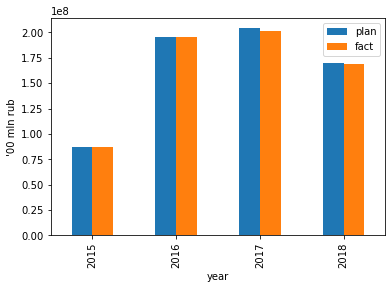

In [188]:
pf_analysis_grouped_plan = pf_analysis.groupby(by='year')['plan_sales'].sum()
pf_analysis_grouped_fact = pf_analysis.groupby(by='year')['fact_sales'].sum()
pf_analysis_grouped = pd.concat([pf_analysis_grouped_plan,
                                 pf_analysis_grouped_fact], keys='year', axis=1)

ax = pf_analysis_grouped.plot.bar()
ax.legend(["plan", "fact"])
ax.set_ylabel("'00 mln rub")

Также причиной снижения выручки по продажам продукта Контур.Бухгалтерия могло стать то, что часть старых и новых клиентов перешли на похожие продукты по сдаче отчетности: Контур-Экстерн (продажи начались в конце 2017) и Контур-Экстерн Малый Бизнес (продажи начались в 2018 году). См.таблицу ниже.

In [189]:
sales_by_product = """SELECT P.product as product,
       strftime('%Y', Bills.PayDate) as year,
       SUM(BC.Cost) as fact_sales
FROM Bills
JOIN BillsContent BC on Bills.bID = BC.bID
JOIN PriceItems PI on BC.piID = PI.piID
JOIN Products P on PI.product = P.product
JOIN Agents A on Bills.scID = A.scID
WHERE A.regionCode = 77
GROUP BY P.product, year"""
sales_by_product = pd.read_sql_query(sales_by_product, connection)
sales_by_product = sales_by_product.pivot(index='product', columns='year', values='fact_sales')
sales_by_product_new = sales_by_product.drop(sales_by_product.columns[0], axis=1)
sales_by_product_new['2015'] = sales_by_product_new['2015'].div(1000).round(2)
sales_by_product_new['2016'] = sales_by_product_new['2016'].div(1000).round(2)
sales_by_product_new['2017'] = sales_by_product_new['2017'].div(1000).round(2)
sales_by_product_new['2018'] = sales_by_product_new['2018'].div(1000).round(2)

sales_by_product_new

year,2015,2016,2017,2018
product,,,,
Бухгалтерия.Контур,86616.34,195146.19,201002.97,169279.7
Диадок,NaN,485025.00,720336.00,571410.0
КЭП,NaN,NaN,NaN,449884.5
КЭП.Универсальный,1527792.00,882804.00,748617.60,595315.2
Контур EDI,580018.80,335499.60,285108.00,225381.6
Контур-Фокус,2025381.60,2661865.20,2269897.20,1792695.6
Контур-Экстерн,NaN,NaN,68971.50,517779.0
Контур-Экстерн Малый Бизнес,NaN,NaN,NaN,388639.2
Контур.Закупки,1910685.00,1108141.50,937963.50,748570.5


Обращаясь к таблице PriceItems, видим, что в наименовании тарифа (колонка piName) помимо наименования продукта, которое есть в отдельной колонке, указан срок действия подписки, и наименование тарифа. Последние два параметра были выделены в отдельные колонки для анализа с помощью регулярных выражений, далее присоединяем данные по фактическим продажам к этой таблице (в силу структуры базы данных, тариф нельзя отнести к плановым данным, поэтому анализ в разрезе тарифов сделан только по фактическим продажам).

In [190]:
sql_tariff_naming = """SELECT piID, piName FROM PriceItems WHERE product = 'Бухгалтерия.Контур'"""
tariff_naming = pd.read_sql_query(sql_tariff_naming, connection)

tariff_naming

,piID,piName
0,15,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
1,136,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
2,180,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
3,195,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
4,225,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
5,240,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
6,270,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
7,45,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
8,75,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."
9,105,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н..."


In [191]:
type_column = []
for name in tariff_naming.piName:
    a = re.search('[\"|(]([а-яА-Я]*)[\"|)]$', name).group(1)
    type_column.append(a)
tariff_naming['type'] = type_column

tariff_naming

,piID,piName,type
0,15,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Лайт
1,136,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Базовый
2,180,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД
3,195,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Лайт
4,225,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД
5,240,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Лайт
6,270,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД
7,45,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Базовый
8,75,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Максимальный
9,105,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД


In [192]:
duration_column = []
for name in tariff_naming.piName:
    a = re.search('сроком на\s*(\d* [\S]*)', name).group(1).strip()
    duration_column.append(a)
tariff_naming['duration'] = duration_column

tariff_naming

,piID,piName,type,duration
0,15,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Лайт,6 мес.
1,136,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Базовый,1 год
2,180,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД,2 мес.
3,195,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Лайт,18 мес.
4,225,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД,3 мес.
5,240,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Лайт,2 года
6,270,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД,4 мес.
7,45,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Базовый,6 мес.
8,75,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",Максимальный,6 мес.
9,105,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",ТД,1 мес.


In [193]:
sql_for_tariff_analysis = """SELECT C.cID,
       cName,
       piName,
       strftime('%m', Bills.PayDate) as fact_month,
       strftime('%Y', Bills.PayDate) as fact_year,
       SUM(BC.Cost)
FROM Bills
         JOIN BillsContent BC on Bills.bID = BC.bID
         JOIN PriceItems PI on BC.piID = PI.piID
         JOIN Agents A on Bills.scID = A.scID
         join Clients C on Bills.cID = C.cID
WHERE PayDate IS NOT NULL AND product = 'Бухгалтерия.Контур' AND A.regionCode = 77
GROUP BY 1, 2, 3, 4, 5"""
tariff_analysis = pd.read_sql_query(sql_for_tariff_analysis, connection)

tariff_analysis

,cID,cName,piName,fact_month,fact_year,SUM(BC.Cost)
0,20,Michael Catalano,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",07,2018,19500.0
1,36,Carly Zhang,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",07,2016,16770.0
2,36,Carly Zhang,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",06,2016,16380.0
3,36,Carly Zhang,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",10,2016,4100.0
4,38,Helen Lal,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",03,2016,12570.0
...,...,...,...,...,...,...
46075,842009,Annik Rousey,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",05,2017,13650.0
46076,842009,Annik Rousey,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",03,2018,9750.0
46077,842011,Connie O'Connell,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",12,2016,16770.0
46078,842013,Christina Chisholm,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",06,2017,17680.0


In [194]:
merge_tariff = pd.merge(tariff_analysis, tariff_naming, on = 'piName')

merge_tariff

,cID,cName,piName,fact_month,fact_year,SUM(BC.Cost),piID,type,duration
0,20,Michael Catalano,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",07,2018,19500.0,240,Лайт,2 года
1,36,Carly Zhang,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",06,2016,16380.0,240,Лайт,2 года
2,38,Helen Lal,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",11,2016,15990.0,240,Лайт,2 года
3,72,Gregory Spicer,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",04,2016,16380.0,240,Лайт,2 года
4,72,Gregory Spicer,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",09,2016,35100.0,240,Лайт,2 года
...,...,...,...,...,...,...,...,...,...
46075,805130,Reinout Blanton,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",06,2016,0.0,270,ТД,4 мес.
46076,823169,Victor Canuto,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",11,2017,0.0,270,ТД,4 мес.
46077,824945,Devin Cao,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",10,2016,0.0,270,ТД,4 мес.
46078,832398,Priscilla Waggoner,"Доступ к сервису ""Бухгалтерия.Контур"" сроком н...",12,2015,0.0,270,ТД,4 мес.


В среднем 83% клиентов пользуются Лайт тарифом, 14% - Базовым и 3% - Максимальным.

,SUM(BC.Cost)
type,
Базовый,92007570.0
Лайт,539722830.0
Максимальный,20314800.0
ТД,0.0


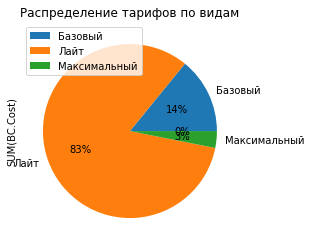

In [195]:
for_pie_chart_1 = merge_tariff.pivot_table(index='type',values='SUM(BC.Cost)', aggfunc='sum')
pie_chart_1 = for_pie_chart_1.plot(kind='pie', y='SUM(BC.Cost)',title='Распределение тарифов по видам', autopct='%1.0f%%')
pie_chart_1.legend(loc="upper left")

for_pie_chart_1

Клиенты в основном (76%) покупают длительную подписку (более года), 18% покупают годовую подписку, остальные 6% - подписку на 6 мес. При таких длительных тарифах важно сохранять долгосрочную лояльность клиентов, качественно оказывать им услуги поддержки.

,SUM(BC.Cost)
duration,
1 год,116343390.0
1 мес.,0.0
18 мес.,177035310.0
2 года,319245790.0
2 мес.,0.0
3 мес.,0.0
4 мес.,0.0
6 мес.,39420710.0


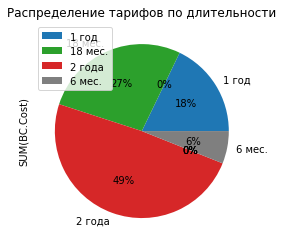

In [196]:
for_pie_chart_2 = merge_tariff.pivot_table(index='duration',values='SUM(BC.Cost)', aggfunc='sum')
pie_chart_1 = for_pie_chart_2.plot(kind='pie', y='SUM(BC.Cost)',title='Распределение тарифов по длительности', autopct='%1.0f%%')
pie_chart_1.legend(loc="upper left")

for_pie_chart_2

Если ТД -  это Триал Доступ (пробный период, т.к. он краткосрочный и колонка оплат пустая), то всего лишь 1% клиентов после использования пробного периода покупает подписку. Компании следует больше продвигать пробный период перед потенциальными клиентами, чтобы они могли оценить все преимущества продукта и перейти из категории "потенциальных" клиентов в фактические.

In [197]:
pivot_by_clients = merge_tariff.pivot_table(index='cName', columns='type', values='SUM(BC.Cost)', aggfunc='count')
pivot_by_clients = pivot_by_clients.fillna(0)
pivot_by_clients['Сумма'] = pivot_by_clients['Базовый'] + pivot_by_clients['Лайт'] + pivot_by_clients['Максимальный'] + pivot_by_clients['ТД']
pivot_by_clients_trials = pivot_by_clients[(pivot_by_clients['ТД']>0)]
pivot_by_clients_trials_and_more = pivot_by_clients_trials[(pivot_by_clients_trials['Сумма']>1)]
future_client_percentage = round(pivot_by_clients_trials_and_more.shape[0]/pivot_by_clients.shape[0],2)

print(f"Доля клиентов, которые после использования пробного периода становятся клиентами компании, составляет {future_client_percentage}")

Доля клиентов, которые после использования пробного периода становятся клиентами компании, составляет 0.01
